# Introduction
* BigTransfer (also known as BiT) is a state-of-the-art transfer learning method for image classification. Transfer of pre-trained representations improves sample efficiency and simplifies hyperparameter tuning when training deep neural networks for vision. BiT revisit the paradigm of pre-training on large supervised datasets and fine-tuning the model on a target task. The importance of appropriately choosing normalization layers and scaling the architecture capacity as the amount of pre-training data increases.

* BigTransfer(BiT) is trained on public datasets, along with code in TF2, Jax and Pytorch. This will help anyone to reach state of the art performance on their task of interest, even with just a handful of labeled images per class.

* You can find BiT models pre-trained on ImageNet and ImageNet-21k in TFHub as TensorFlow2 SavedModels that you can use easily as Keras Layers. There are a variety of sizes ranging from a standard ResNet50 to a ResNet152x4 (152 layers deep, 4x wider than a typical ResNet50) for users with larger computational and memory budgets but higher accuracy requirements.

![](https://i.imgur.com/XeWVfe7.jpeg)

**Figure: The x-axis shows the number of images used per class, ranging from 1 to the full dataset. On the plots on the left, the curve in blue above is our BiT-L model, whereas the curve below is a ResNet-50 pre-trained on ImageNet (ILSVRC-2012).**

# Setup

In [1]:
!pip install tensorflow-datasets --upgrade

In [2]:
import os
# os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import keras
from keras import ops
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import os
import sys
SEEDS = 42

keras.utils.set_random_seed(SEEDS)

In [3]:
# Print environment information to help diagnose issues
print(f"TensorFlow version: {tf.__version__}")
print(f"Python version: {sys.version}")

# Check for TPU-specific environment variables
tpu_env_vars = {k: v for k, v in os.environ.items() if 'TPU' in k}
if tpu_env_vars:
    print("TPU environment variables found:")
    for k, v in tpu_env_vars.items():
        print(f"  {k}: {v}")
else:
    print("No TPU environment variables found")
    # Try setting TPU name environment variable
    os.environ["TPU_NAME"] = "grpc://10.0.0.1:8470"
    print("Set TPU_NAME to grpc://10.0.0.1:8470")

# Check for available physical devices
physical_devices = tf.config.list_physical_devices()
print("\nPhysical devices:")
for device in physical_devices:
    print(f"  {device.name} ({device.device_type})")

# Try multiple approaches to detect TPU
print("\nAttempting TPU detection:")

# Approach 1: Standard resolver
try:
    print("Approach 1: Standard resolver")
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f"  TPU detected: {resolver.master()}")
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print(f"  Success: {strategy.num_replicas_in_sync} replicas")
except Exception as e:
    print(f"  Failed: {e}")

    # Approach 2: Local TPU
    try:
        print("\nApproach 2: Local TPU")
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver('local')
        print(f"  TPU detected: {resolver.master()}")
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.TPUStrategy(resolver)
        print(f"  Success: {strategy.num_replicas_in_sync} replicas")
    except Exception as e:
        print(f"  Failed: {e}")

        # Approach 3: Experimental TPU Strategy
        try:
            print("\nApproach 3: Experimental TPU Strategy")
            resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
            print(f"  TPU detected: {resolver.master()}")
            tf.config.experimental_connect_to_cluster(resolver)
            tf.tpu.experimental.initialize_tpu_system(resolver)
            strategy = tf.distribute.experimental.TPUStrategy(resolver)
            print(f"  Success: {strategy.num_replicas_in_sync} replicas")
        except Exception as e:
            print(f"  Failed: {e}")
            
            # Fallback to default strategy
            print("\nFalling back to default strategy")
            strategy = tf.distribute.get_strategy()

print(f"\nFinal strategy: {strategy.__class__.__name__}")
print(f"Number of replicas: {strategy.num_replicas_in_sync}")

TensorFlow version: 2.17.1
Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
TPU environment variables found:
  COLAB_TPU_1VM: 
  TPU_ML_PLATFORM: Tensorflow
  TPU_ML_PLATFORM_VERSION: 2.17.1

Physical devices:
  /physical_device:CPU:0 (CPU)
  /physical_device:GPU:0 (GPU)

Attempting TPU detection:
Approach 1: Standard resolver
  Failed: Please provide a TPU Name to connect to.

Approach 2: Local TPU
  TPU detected: 
  Failed: TPUs not found in the cluster. Failed in initialization: No OpKernel was registered to support Op 'ConfigureDistributedTPU' used by {{node ConfigureDistributedTPU}} with these attrs: [compilation_failure_closes_chips=false, embedding_config="", enable_whole_mesh_compilations=false, is_global_init=false, tpu_embedding_config="", tpu_cancellation_closes_chips=2]
Registered devices: [CPU, GPU]
Registered kernels:
  <no registered kernels>

	 [[ConfigureDistributedTPU]] [Op:__inference__tpu_init_fn_4]

Approach 3: Experimental TPU Strategy
  Failed: 

# Gather Flower Dataset

In [4]:

train_ds, validation_ds = tfds.load("tf_flowers",split=["train[:85%]", "train[85%:]"],as_supervised=True)

In [5]:
builder = tfds.builder("tf_flowers")
builder.download_and_prepare()  # Only required the first time
info = builder.info

class_names = info.features['label'].names

print("Class names:", class_names)

Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


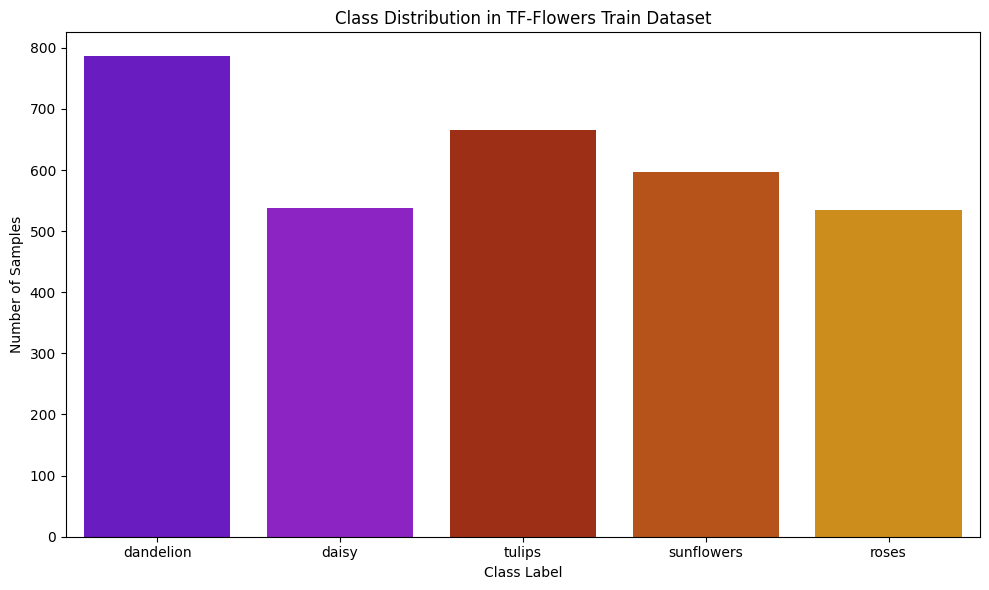

In [6]:
class_labels = []
for image, label in train_ds:
    class_labels.append(int(label))

df = pd.DataFrame(class_labels, columns=['label'])

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', palette='gnuplot')
plt.title("Class Distribution in TF-Flowers Train Dataset")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.xticks(ticks=range(5), labels=class_names) 
plt.tight_layout()
plt.show()

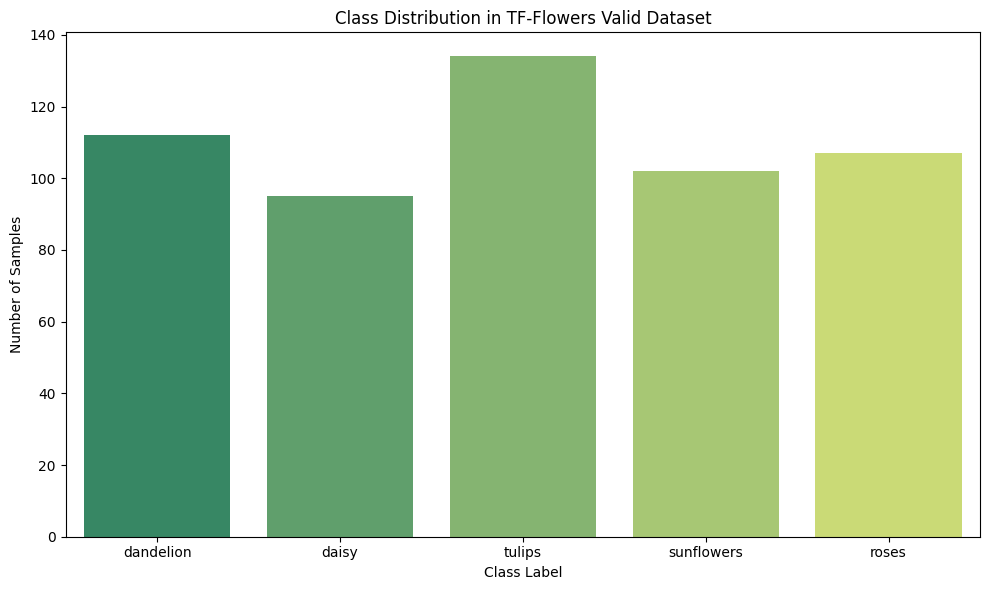

In [7]:
class_labels = []
for image, label in validation_ds:
    class_labels.append(int(label))

df = pd.DataFrame(class_labels, columns=['label'])

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', palette='summer')
plt.title("Class Distribution in TF-Flowers Valid Dataset")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.xticks(ticks=range(5), labels=class_names) 
plt.tight_layout()
plt.show()

# Visualise the dataset


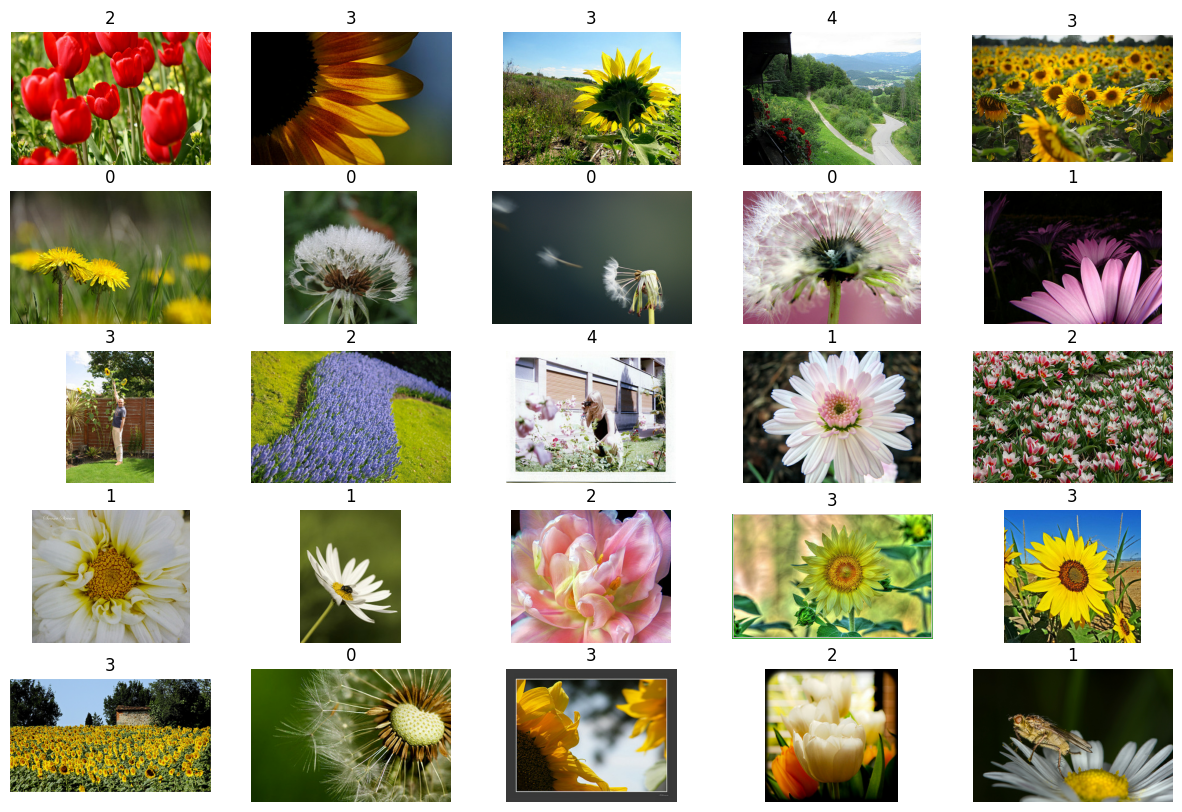

In [8]:
plt.figure(figsize=(15, 10))
for i, (image, label) in enumerate(train_ds.take(25)):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")
plt.show()

# Define hyperparameters

In [9]:
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 8
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 5  # number of classes
SCHEDULE_LENGTH = (500)
SCHEDULE_BOUNDARIES = [200, 300,400] # more the dataset size the schedule length increase

learning_rate = 0.003 * BATCH_SIZE / 512

* The hyperparamteres like SCHEDULE_LENGTH and SCHEDULE_BOUNDARIES are determined based on empirical results. The method has been explained in the original paper and in their Google AI Blog Post.

* The SCHEDULE_LENGTH is aslo determined whether to use MixUp Augmentation or not. You can also find an easy MixUp Implementation in Keras Coding Examples.

![](https://i.imgur.com/oSaIBYZ.jpeg)

# Define preprocessing helper functions

In [10]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 256 / BATCH_SIZE

random_flip = keras.layers.RandomFlip("horizontal")
random_crop = keras.layers.RandomCrop(CROP_TO, CROP_TO)

def preprocess_train(image, label):
    image = random_flip(image)
    image = ops.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = random_crop(image)
    image = image / 255.0
    return (image, label)


def preprocess_test(image, label):
    image = ops.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = ops.cast(image, dtype="float32")
    image = image / 255.0
    return (image, label)


In [11]:
DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH)
repeat_count += 50 + 1  # To ensure at least there are 50 epochs of training

# Define the data pipeline

In [12]:
# Training pipeline
pipeline_train = (train_ds.shuffle(10000).repeat(repeat_count).map(preprocess_train, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO))

# Validation pipeline
pipeline_validation = (validation_ds.map(preprocess_test, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO))

In [13]:
image_batch, label_batch = next(iter(pipeline_train))
print(f"Image Shape : {image_batch.shape}")
print(f"Label Shape : {label_batch.shape}")

Image Shape : (8, 224, 224, 3)
Label Shape : (8,)


# Visualise the training samples

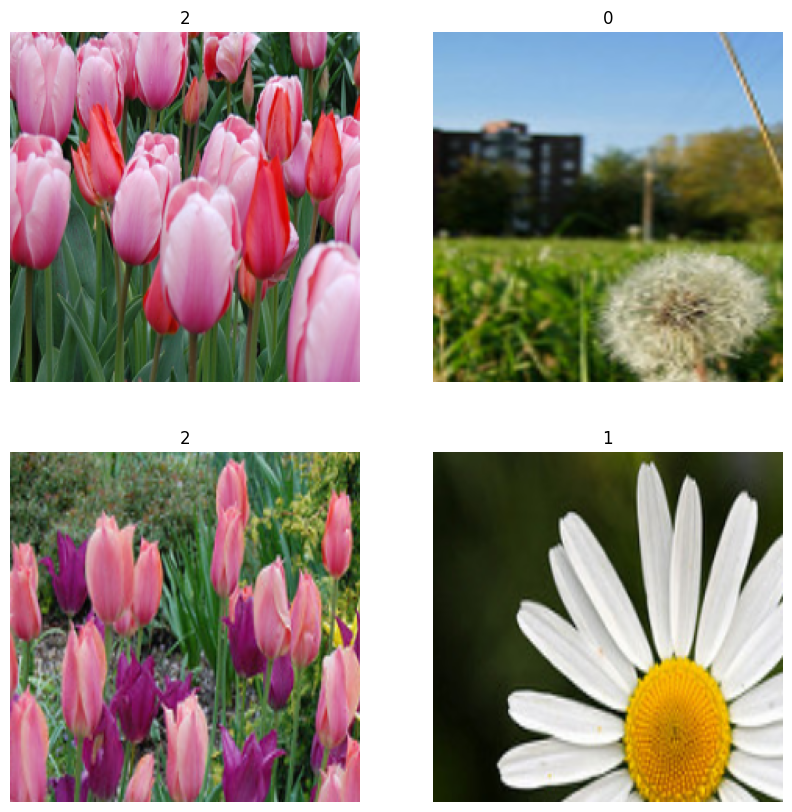

In [14]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(4):
    ax = plt.subplot(2, 2, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")
plt.show()

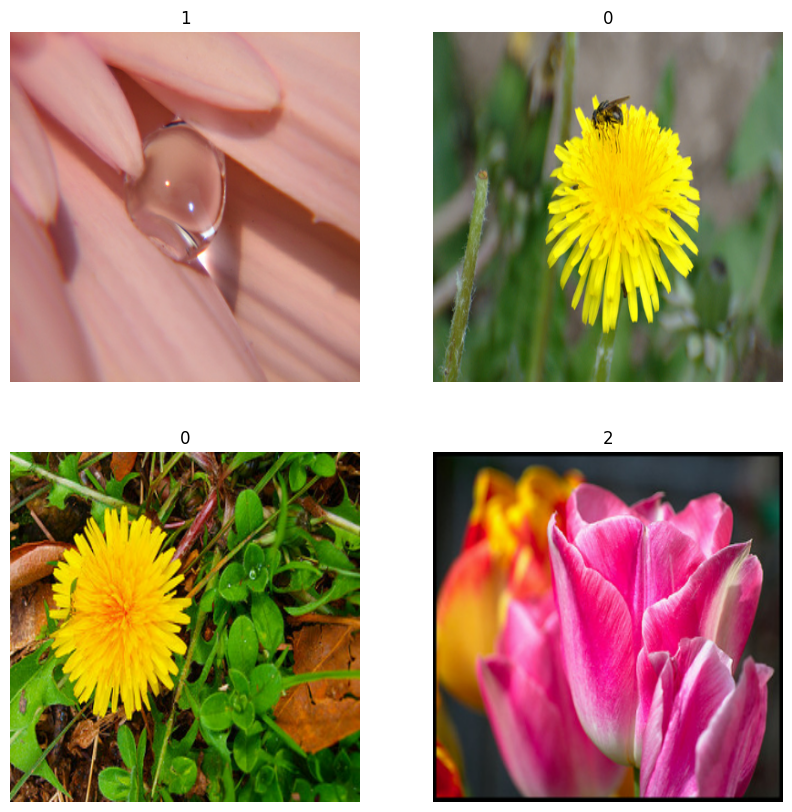

In [15]:
image_batch, label_batch = next(iter(pipeline_validation))

plt.figure(figsize=(10, 10))
for n in range(4):
    ax = plt.subplot(2, 2, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")
plt.show()

# Load pretrained TF-Hub model into a KerasLayer

In [16]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.load(bit_model_url)

# Create BigTransfer (BiT) model

# To create the new model, we:

* Cut off the BiT model’s original head. This leaves us with the “pre-logits” output. We do not have to do this if we use the ‘feature extractor’ models (i.e. all those in subdirectories titled feature_vectors), since for those models the head has already been cut off.

* Add a new head with the number of outputs equal to the number of classes of our new task. Note that it is important that we initialise the head to all zeroes.

In [17]:
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)

with strategy.scope():
    
        
    model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

# Define optimizer and loss


In [18]:
earning_rate = 0.003 * BATCH_SIZE / 512

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,values=[
                                                                learning_rate,
                                                                learning_rate * 0.1,
                                                                learning_rate * 0.01,
                                                                learning_rate * 0.001])

optimizer = keras.optimizers.Adam(learning_rate=0.00001)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])



# Set up callbacks

In [19]:
train_callbacks = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)]

# Train the model

In [20]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=4,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

Epoch 1/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 426s 41s/step - accuracy: 0.3900 - loss: 1.5967 - val_accuracy: 0.8382 - val_loss: 1.5537
Epoch 2/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 389s 39s/step - accuracy: 0.7683 - loss: 1.5336 - val_accuracy: 0.7636 - val_loss: 1.4988
Epoch 3/4
10/10 ━━━━━━━━━━━━━━━━━━━━ 389s 39s/step - accuracy: 0.9154 - loss: 1.4514 - val_accuracy: 0.7418 - val_loss: 1.4442


# Loss & Accuracy Graph

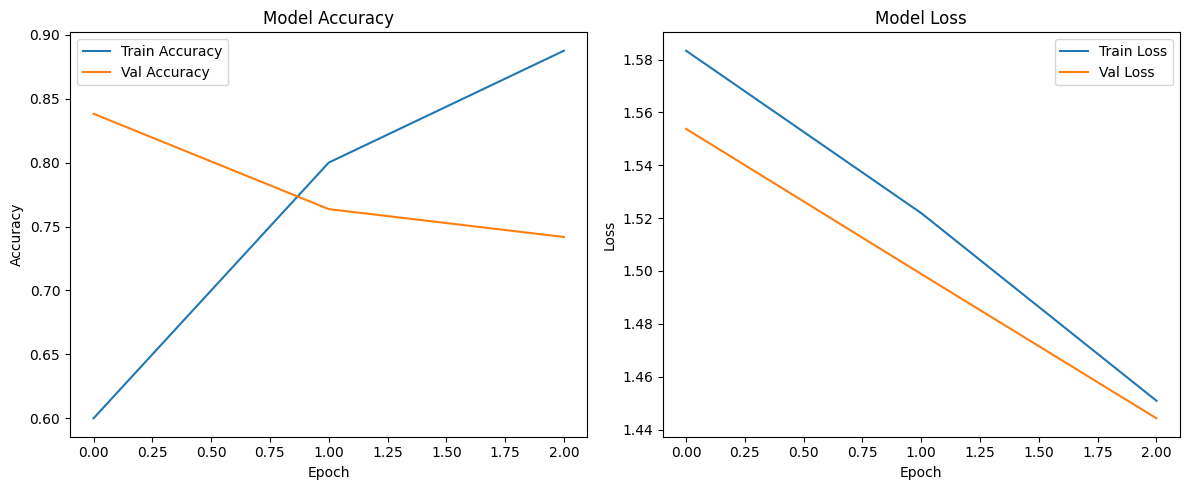

In [21]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate the model

In [22]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8473 - loss: 1.5535
Accuracy: 83.82%


In [23]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Confusion Matrix

69/69 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step


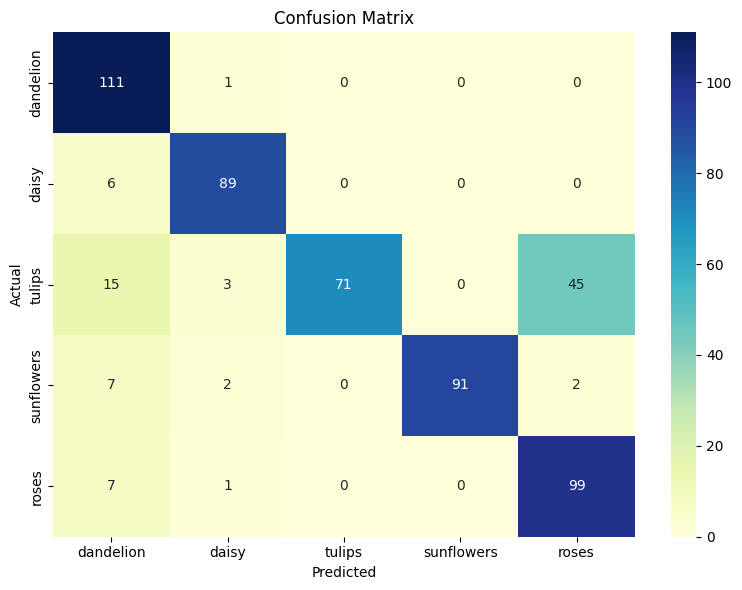

In [24]:
y_pred_probs = model.predict(pipeline_validation)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for _, y in pipeline_validation], axis=0)

class_names = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification report

In [25]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   dandelion       0.76      0.99      0.86       112
       daisy       0.93      0.94      0.93        95
      tulips       1.00      0.53      0.69       134
  sunflowers       1.00      0.89      0.94       102
       roses       0.68      0.93      0.78       107

    accuracy                           0.84       550
   macro avg       0.87      0.86      0.84       550
weighted avg       0.88      0.84      0.83       550



# Model Evaluation Metrics

In [26]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1)

Accuracy: 0.8381818181818181
Weighted Precision: 0.8759607202158572
Weighted Recall: 0.8381818181818181
Weighted F1-score: 0.8320932646621496


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step


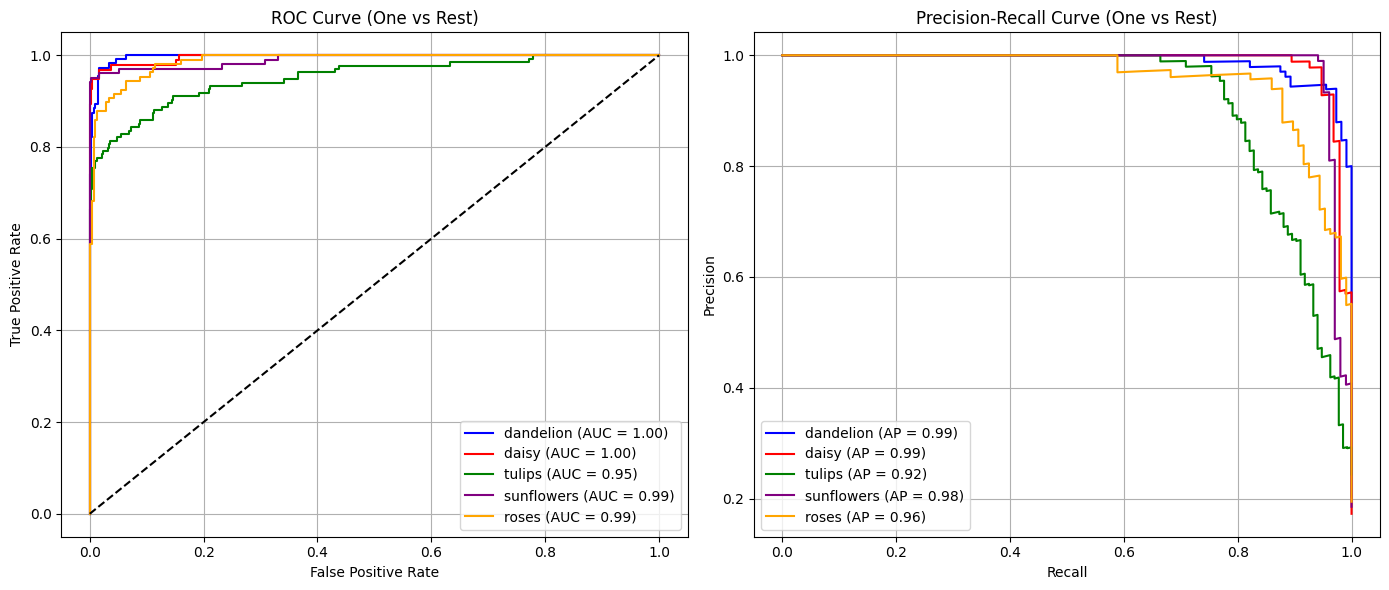

In [27]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_true = np.concatenate([y for _, y in pipeline_validation], axis=0)
y_pred_probs = model.predict(pipeline_validation)
n_classes = y_pred_probs.shape[1]
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])

class_names = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
colors = ['blue', 'red', 'green', 'purple', 'orange']

# Plot ROC and PR side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curves
for i, color in zip(range(n_classes), colors):
    ax1.plot(fpr[i], tpr[i], color=color, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_title('ROC Curve (One vs Rest)')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')
ax1.grid(True)

# PR Curves
for i, color in zip(range(n_classes), colors):
    ax2.plot(recall[i], precision[i], color=color, label=f'{class_names[i]} (AP = {avg_precision[i]:.2f})')
ax2.set_title('Precision-Recall Curve (One vs Rest)')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc='lower left')
ax2.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


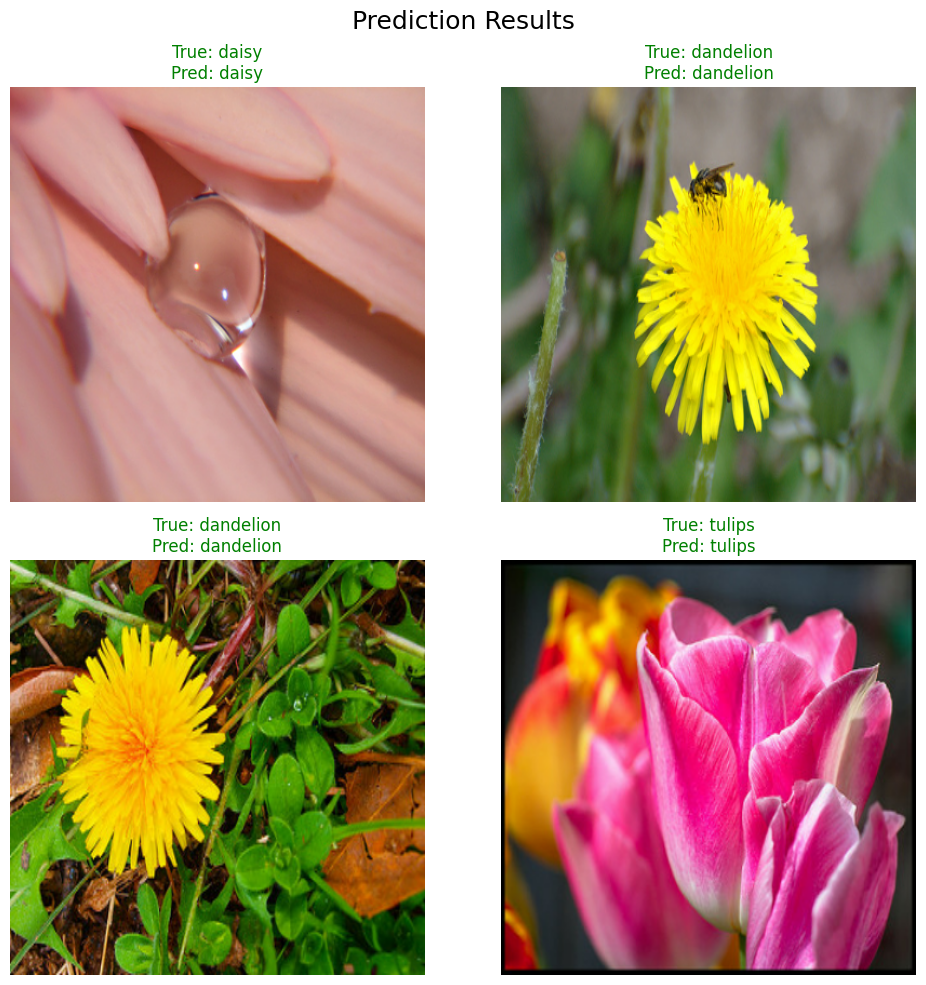

In [28]:

images, labels = next(iter(pipeline_validation))

# Predict
pred_probs = model.predict(images)
y_pred = np.argmax(pred_probs, axis=1)

# If labels are already integer encoded (not one-hot), use directly
y_true = labels.numpy().astype(int)

class_names = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

# Plot 2x2 image grid
plt.figure(figsize=(10, 10))
for i in range(4):
    img = images[i].numpy()
    true_label = class_names[y_true[i]]
    pred_label = class_names[y_pred[i]]
    correct = (y_true[i] == y_pred[i])
    
    color = 'green' if correct else 'red'
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis('off')
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(3)

plt.suptitle("Prediction Results", fontsize=18)
plt.tight_layout()
plt.show()
